In [39]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mvn
from utils import MPCTrajectory
from utils import systematic_resampling, stratified_resampling, residual_resampling, CarTrajectoryLinear, CarTrajectoryNonLinear
from tqdm import tqdm
from utils import PF
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d

In [40]:
def plot_particle(states, state_estimates, measurements, particle_history):
    n = len(states)
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))

    # Plot particle history
    blues = get_cmap('Blues')(np.linspace(0.2, 1.0, n))
    for k in range(n):
        ax.scatter(particle_history[k, :, 0], particle_history[k, :, 1], s=1, color=blues[k])

    points = state_estimates[:, :2]
    points = interp1d(np.arange(n), points, axis=0)(np.linspace(0, n - 1, 10000))
    points = points.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    #lc1 = LineCollection(segments, colors=greys, linewidths=3, edgecolors='k', linestyle='--')
    lc1_color = get_cmap('Greys')(np.linspace(0.5, 1, len(segments)))[::-1]
    lc1 = LineCollection(segments, colors=lc1_color, linewidths=4, linestyles='solid')

    lc2_color = get_cmap('Blues')(np.linspace(0.2, 1, len(segments)))[::-1]
    lc2 = LineCollection(segments, colors=lc2_color, linewidths=1.5, linestyles='solid', label='Estimated')

    ax.add_collection(lc1)
    ax.add_collection(lc2)

    greys = get_cmap('Greys')(np.linspace(0.5, 1, n))[::-1]
    ax.scatter(measurements[:, 0], measurements[:, 1], s=15, c=greys, marker='^')

    blues = get_cmap('Blues')(np.linspace(0.2, 1, n))[::-1]
    ax.scatter(measurements[:, 0], measurements[:, 1], s=7.5, c=blues, marker='^')
    
    ax.plot(states[:, 0], states[:, 1], color='k', linewidth=2, linestyle='solid', label='True')

    ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
    ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
    ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
    ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

    ax.set_xlim(-5, 51)
    ax.set_ylim(-5, 26)
    ax.set_aspect('equal')
    
    # Caluclate and show MSE
    mse = np.mean(np.linalg.norm(states[:, :2] - state_estimates[:, :2], axis=1))
    ax.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')

    #ax.legend()

    plt.show()

In [41]:
def c(state):
    x, y, _, _ = state
    if 1 <= x <= 40:
        if 1 <= y <= 5:
            return True
    if 40 < x <= 45:
        if 1 <= y <= 20:
            return True
    return False

def c2(state):
    x, y, dx, dy = state
    if 1 <= x <= 40:
        if 1 <= y <= 5:
            return True
    if 40 < x <= 45:
        if 1 <= y <= 20:
            return True
    return False

In [42]:
def line_search(m, h, c):
    start = m
    end = h

    while np.linalg.norm(start - end) > 1e-6:
        mid = (start + end) / 2
        if c(mid):
            start = mid
        else:
            end = mid

    return end

In [43]:
class PF_CONSTRAINED:
    def __init__(self, f, h, Q, R, dim_m = 4, dim_y = 2, N=500, resample_criterion = False):
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R
        self.dim_m = dim_m
        self.dim_y = dim_y
        self.N = N
        self.resample_criterion = resample_criterion
        
        assert dim_m == len(Q)
        assert dim_y == len(R)
        
        
    def resample(self, particles, weights, method = 'systematic'):
        if not self.resample_criterion or 1. / np.sum(np.square(weights)) < self.N / 2:
            if method == 'systematic':
                indexes = systematic_resampling(weights)
            elif method == 'residual':
                indexes = residual_resampling(weights)
            elif method == 'stratified':
                indexes = stratified_resampling(weights)
            else:
                raise ValueError('Unknown resampling method')
            
            return particles[indexes], np.ones(self.N) / self.N
        else:
            return particles, weights
        
    def predict(self, particles, weights):
        for i, particle in enumerate(particles):
            particles[i] = mvn(self.f(particle), self.Q).rvs()
            
        return particles, weights
    
    def update(self, y, particles, weights):
        
        m = np.average(particles, weights=weights, axis=0)
        
        if c(m):
            for i, particle in enumerate(particles):
                if c(particle):
                    particles[i] = particle
                    weights[i] *= mvn(self.h(particles[i]), self.R).pdf(y)
                else:
                    particles[i] = line_search(m, particle, c)
                    weights[i] *= mvn(self.h(particles[i]), self.R).pdf(y)
                        
        else:
            for i, particle in enumerate(particles):
                #weights[i] *= (mvn(self.h(particle), self.R).pdf(y) if c(particle) else 0)
                weights[i] *= mvn(self.h(particle), self.R).pdf(y)
            
        weights /= np.sum(weights)
        
        return particles, weights
    
    def filter(self, measurements, m = None, P = None, resampling_method = 'systematic', verbose = True):
        if m is None: m = np.zeros(self.dim_m)
        if P is None: P = np.eye(self.dim_m)
        
        n = len(measurements)
        state_estimates = np.empty((n, self.dim_m))
        cov_estimates = np.empty((n, self.dim_m, self.dim_m))
        particle_history = np.empty((n, self.N, self.dim_m))
        resampled_history = np.empty((n, self.N, self.dim_m))
        weights_history = np.empty((n, self.N))

        # Draw N samples from the prior
        particles = mvn(m, P).rvs(self.N)
        weights = np.ones(self.N) / self.N
        
        if verbose:
            iterator = tqdm(enumerate(measurements), total=n)
        else:
            iterator = enumerate(measurements)
        
        for k, y in iterator:
            particles, weights = self.predict(particles, weights)
            particles, weights = self.update(y, particles, weights)            
            
            m = np.average(particles, weights=weights, axis=0)
            P = np.sum([weights[i] * np.outer(particles[i] - m, particles[i] - m)
                        for i in range(self.N)], axis=0)
            
            state_estimates[k] = m
            cov_estimates[k] = P
            particle_history[k] = particles
            weights_history[k] = weights
            
            particles, weights = self.resample(particles, weights, resampling_method)
            resampled_history[k] = particles
            
        return state_estimates, cov_estimates, particle_history, weights_history, resampled_history
    
    # Particle Rauch-Tung-Striebel (URTS) Smoother
    def smoother(self, state_estimates, cov_estimates, particle_history, weights_history, verbose = True):
        n = len(state_estimates)
        state_estimates_smoothed = np.empty((n, self.dim_m))
        state_estimates_smoothed[-1] = state_estimates[-1]
        cov_estimates_smoothed = np.empty((n, self.dim_m, self.dim_m))
        cov_estimates_smoothed[-1] = cov_estimates[-1]
        
        if verbose:
            iterator = tqdm(range(n - 2, -1, -1), initial=1, total=n)
        else:
            iterator = range(n - 2, -1, -1)

        for k in iterator:
            m = state_estimates[k]
            P = cov_estimates[k]
            
            weights = weights_history[k]
            particles = particle_history[k]

            particles_transformed = np.empty_like(particles)
            for i, particle in enumerate(particles):
                particles_transformed[i] = self.f(particle)
            
            m_pred = np.average(particles_transformed, weights=weights, axis=0)
            P_pred = np.sum([weights[i] * np.outer(particles_transformed[i] - m_pred, particles_transformed[i] - m_pred)
                             for i in range(self.N)], axis=0) + self.Q
            
            D = np.sum([weights[i] * np.outer(particles[i] - m, particles_transformed[i] - m_pred)
                        for i in range(self.N)], axis=0)
            G = D @ np.linalg.inv(P_pred)
            
            state_estimates_smoothed[k] = m + G @ (state_estimates_smoothed[k + 1] - m_pred)
            cov_estimates_smoothed[k] = P + G @ (cov_estimates_smoothed[k + 1] - P_pred) @ G.T
            
        return state_estimates_smoothed, cov_estimates_smoothed

In [44]:
trajectory = MPCTrajectory()
states, measurements = trajectory.get_data()
states = states[::2]
measurements = measurements[::2]
n = len(states)

MPC: 0it [00:00, ?it/s]

In [ ]:
system = CarTrajectoryLinear()

f = lambda f: system.A @ f
h = trajectory.h
Q = system.Q
R = trajectory.R

In [ ]:
#particle_filter = PF_CONSTRAINED(f, h, Q, R, dim_m = 4, dim_y = 2)
particle_filter = PF(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates_uncon, cov_estimates_uncon, particle_history_uncon, weights_history_uncon = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_uncon, cov_estimates_smoothed_uncon = particle_filter.smoother(state_estimates_uncon, cov_estimates_uncon, particle_history_uncon, weights_history_uncon, verbose=True)

  0%|          | 0/154 [00:00<?, ?it/s]

  1%|          | 1/154 [00:00<?, ?it/s]

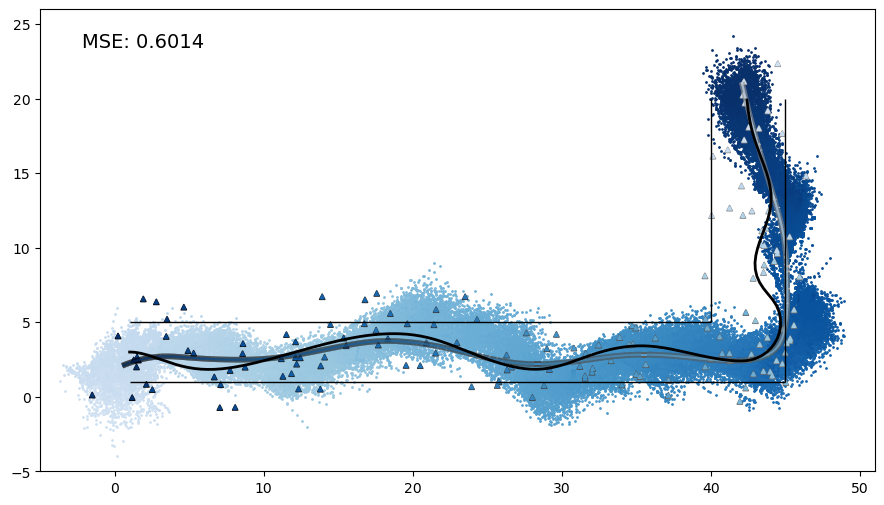

In [ ]:
plot_particle(states, state_estimates_smoothed_uncon, measurements, particle_history_uncon)

In [ ]:
#particle_filter = PF_CONSTRAINED(f, h, Q, R, dim_m = 4, dim_y = 2)
particle_filter = PF_CONSTRAINED(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, resampled_history_con = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con, cov_estimates_smoothed_con = particle_filter.smoother(state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, verbose=True)

100%|██████████| 154/154 [00:01<00:00, 150.29it/s]


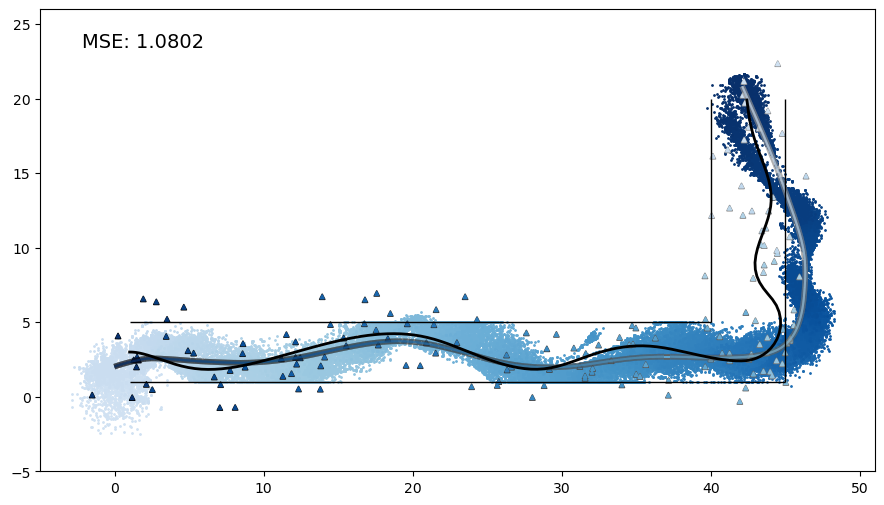

In [ ]:
plot_particle(states, state_estimates_smoothed_con, measurements, particle_history_con)

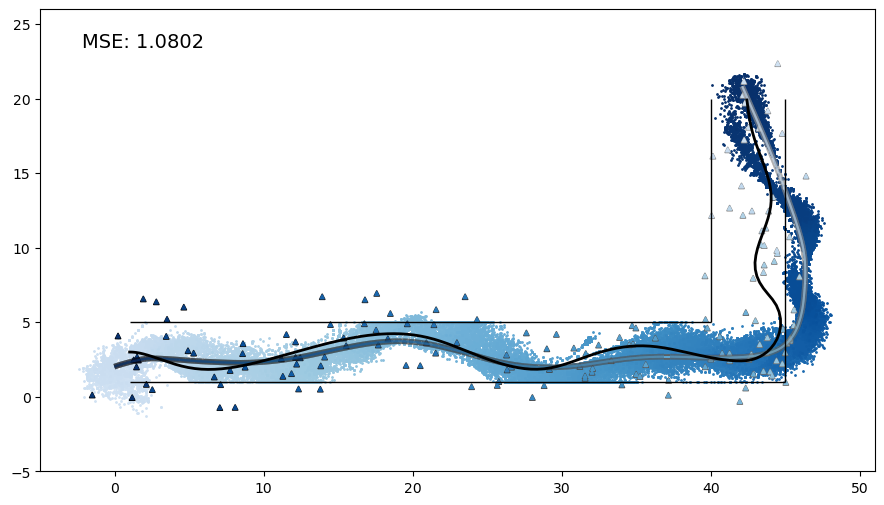

In [ ]:
plot_particle(states, state_estimates_smoothed_con, measurements, resampled_history_con)

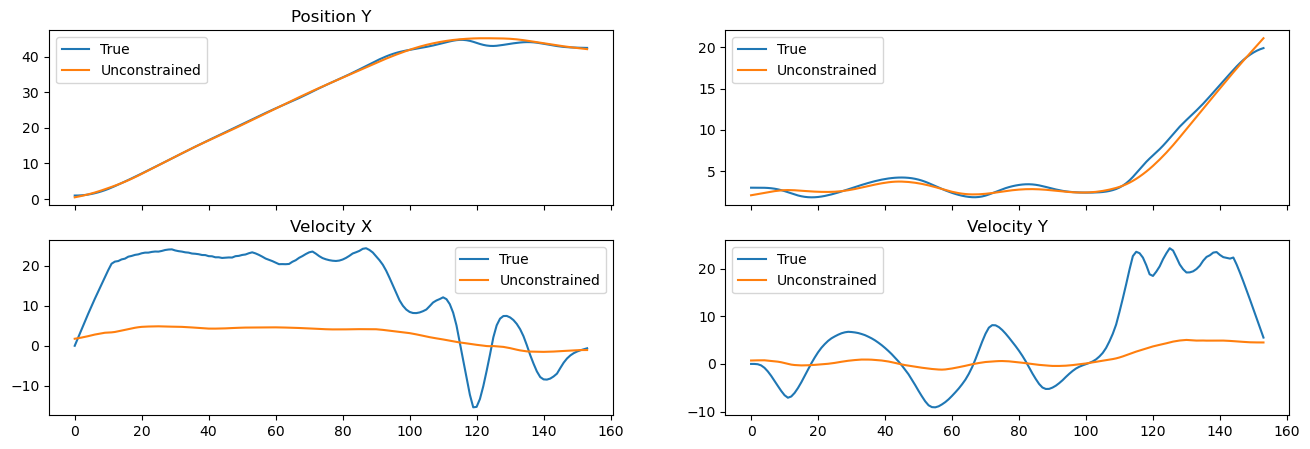

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(16, 5), sharex=True)
ax[0, 0].plot(states[:, 0], label='True')
ax[0, 0].plot(state_estimates_smoothed_uncon[:, 0], label='Unconstrained')
ax[0, 0].set_title('Position X')

ax[0, 1].plot(states[:, 1], label='True')
ax[0, 1].plot(state_estimates_smoothed_uncon[:, 1], label='Unconstrained')
ax[0, 0].set_title('Position Y')

ax[1, 0].plot(states[:, 2], label='True')
ax[1, 0].plot(state_estimates_smoothed_uncon[:, 2], label='Unconstrained')
ax[1, 0].set_title('Velocity X')

ax[1, 1].plot(states[:, 3], label='True')
ax[1, 1].plot(state_estimates_smoothed_uncon[:, 3], label='Unconstrained')
ax[1, 1].set_title('Velocity Y')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

plt.show()

In [37]:
A

NameError: name 'A' is not defined

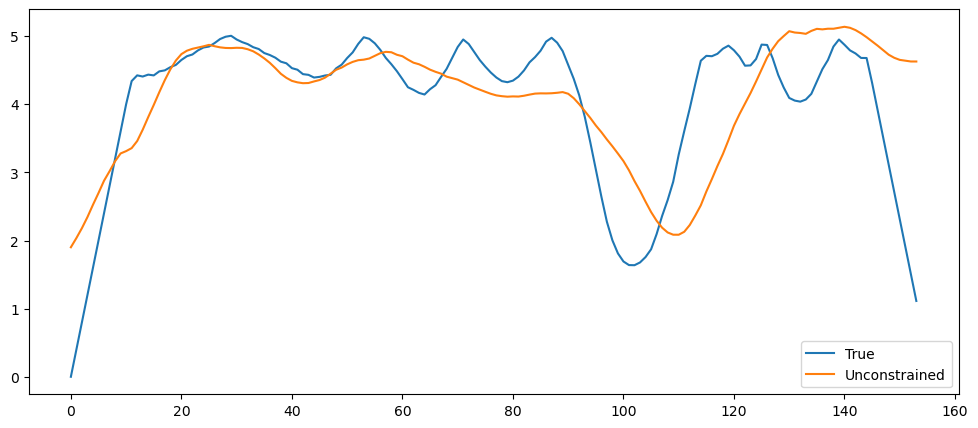

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharex=True)
ax.plot(np.sqrt(states[:, 2]**2 + states[:, 3]**2) * 0.2, label='True')
ax.plot(np.sqrt(state_estimates_smoothed_uncon[:, 2]**2 + state_estimates_smoothed_uncon[:, 3]**2), label='Unconstrained')
ax.legend()